In [14]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import math
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])


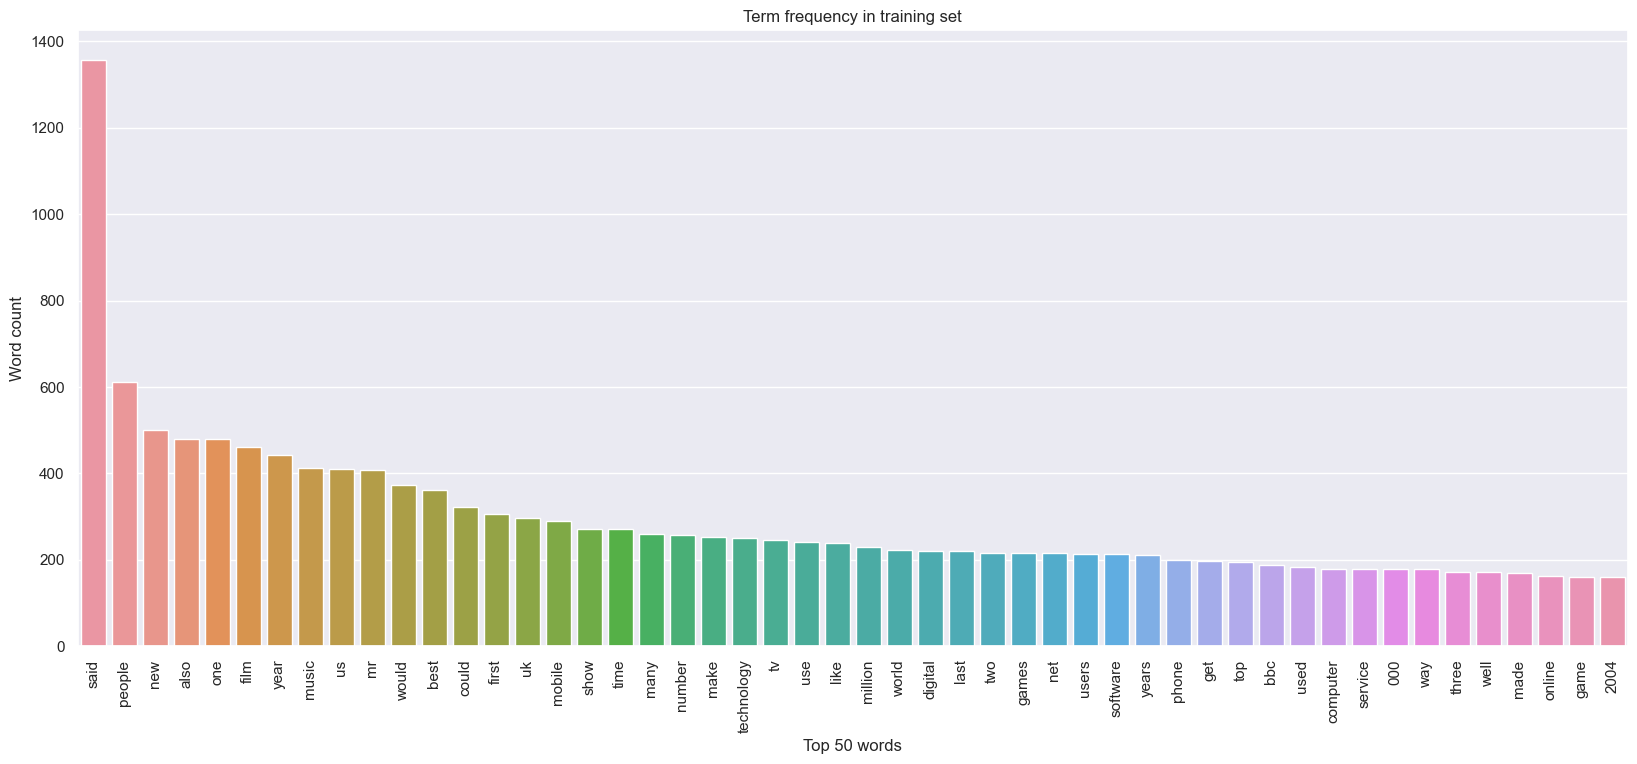

In [9]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

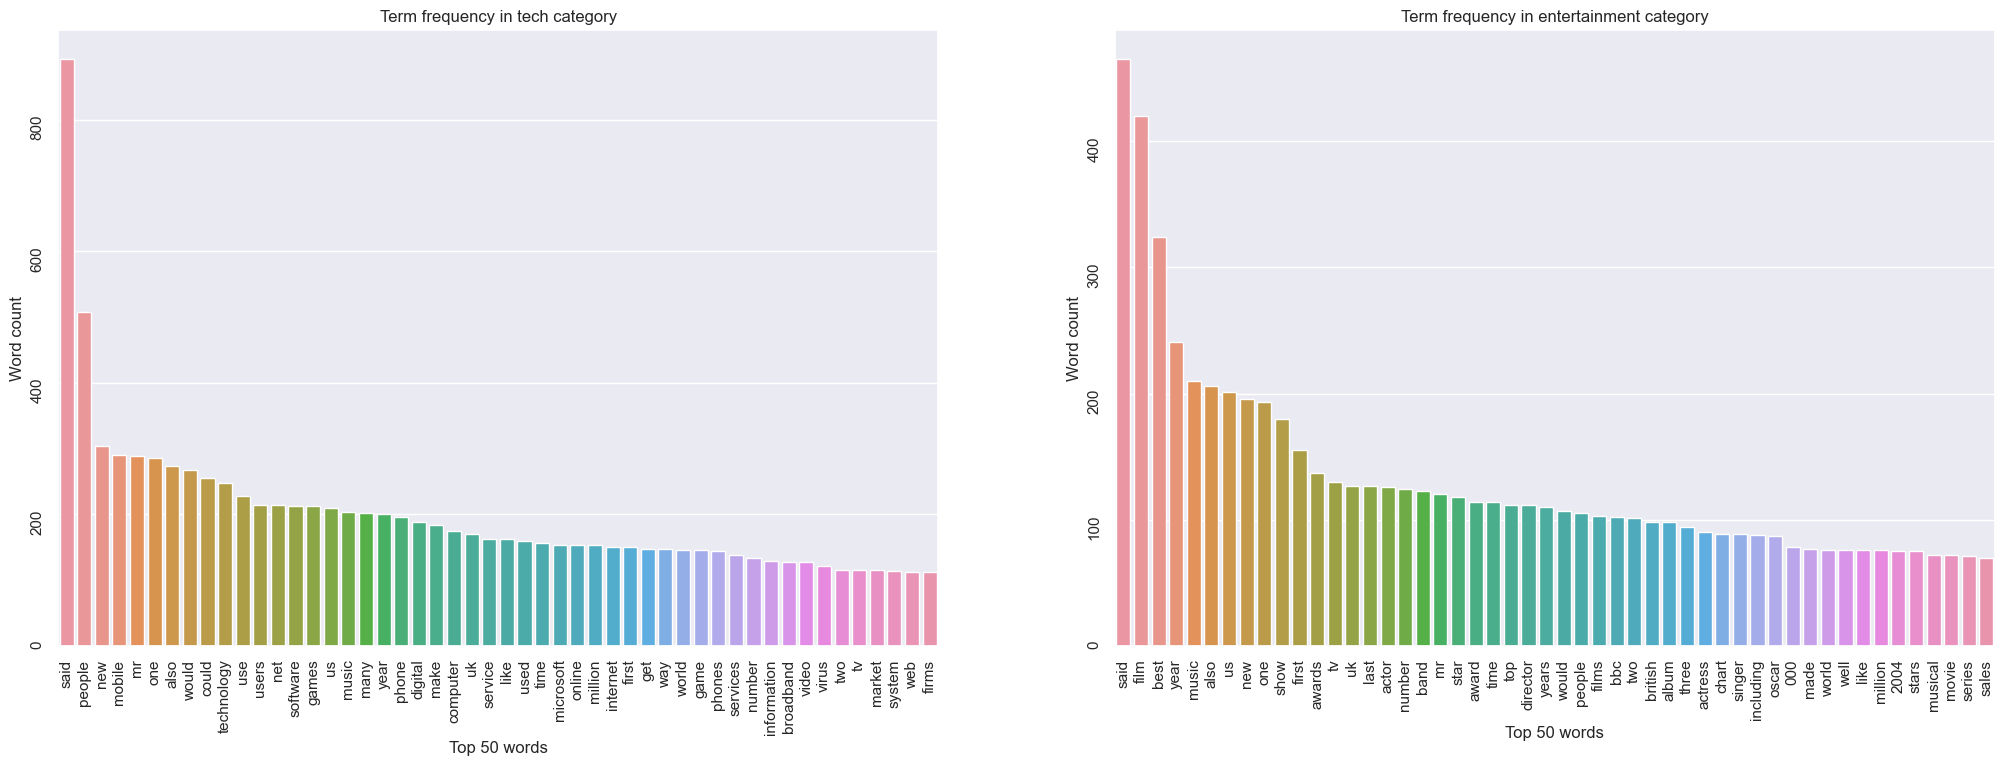

In [10]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

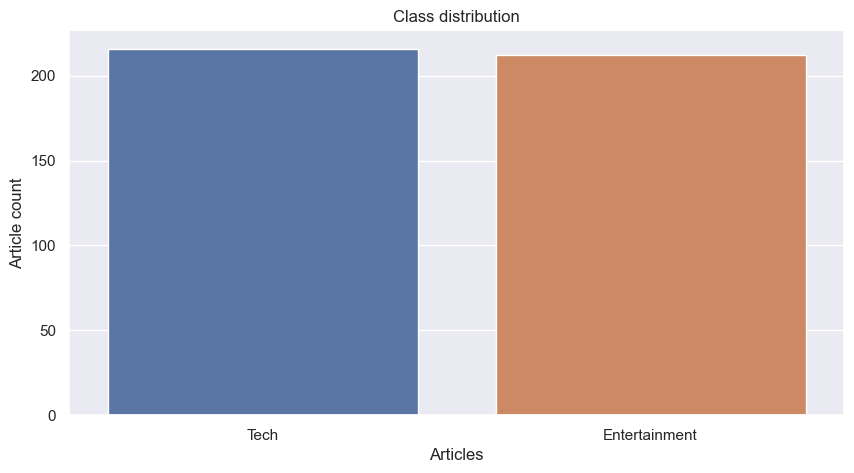

In [11]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [12]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
# summarize
# print(f'vector vocabulary - {vectorizer.vocabulary_}\n')

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import warnings

#warnings.filterwarnings('ignore')

#np.random.seed(1)

init_weigths = np.random.uniform(0., 0.1, 13518)
hid_units = [5,20,40]
results = []

for hid_unit in hid_units:
    clf = MLPClassifier(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.coefs_ = init_weigths

    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    score = clf.score(prep_X_test, Y_test)

    loss = log_loss(Y_test, preds)
    results.append([hid_unit, loss, score])

print(results)

[[5, 0.3400344659350677, 0.9905660377358491], [20, 0.6800689318701351, 0.9811320754716981], [40, 0.3400344659350677, 0.9905660377358491]]


[]

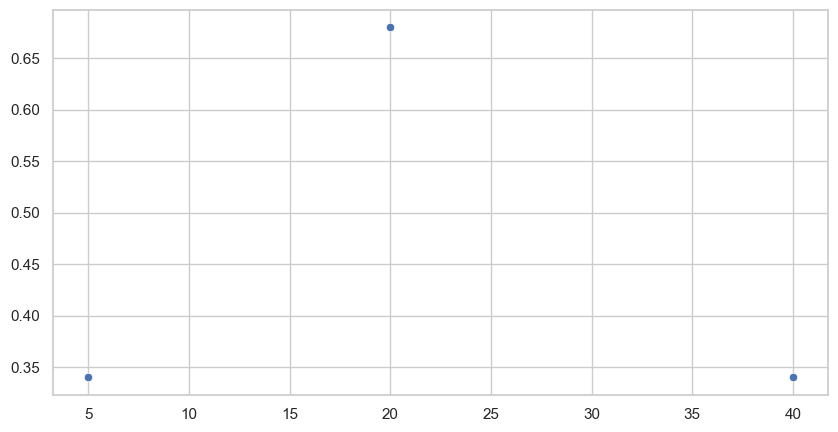

In [80]:
sns.set_style('whitegrid')
results = np.array(results).T
plot = sns.scatterplot(x=results[0], y=results[1])
plt.plot()

# Task 2C: SVM

### Method: 

The decision boundaries are drawn by transforming the data into two dimenions using PCA, then training the model on the transformed data. We found this necessary because of the difficulty of drawing a decision boundary graph using the original data with many more dimensions.


By training the model AFTER undergoing a PCA transform, the decision boundaries do not accurately reflect how the model will perform on the actual data set. This is because the data is more separable in the original dimensional space. We see this in the preliminary data exploration: for example, words such as "movie", "star", etc are indicators of an article in the entertainment class. Two data points in the "tech" class seem to be outliers in the boundary plots. If we keep the original dimensional space, these may not be outliers.

We also create a plots of the hyperparameter vs the test f1-score. This is using the non-PCA data, so we will refer to this plot when talking about the effect on the hyperparameter on the actual performance of the data.

## Hard-margin RBF SVM 

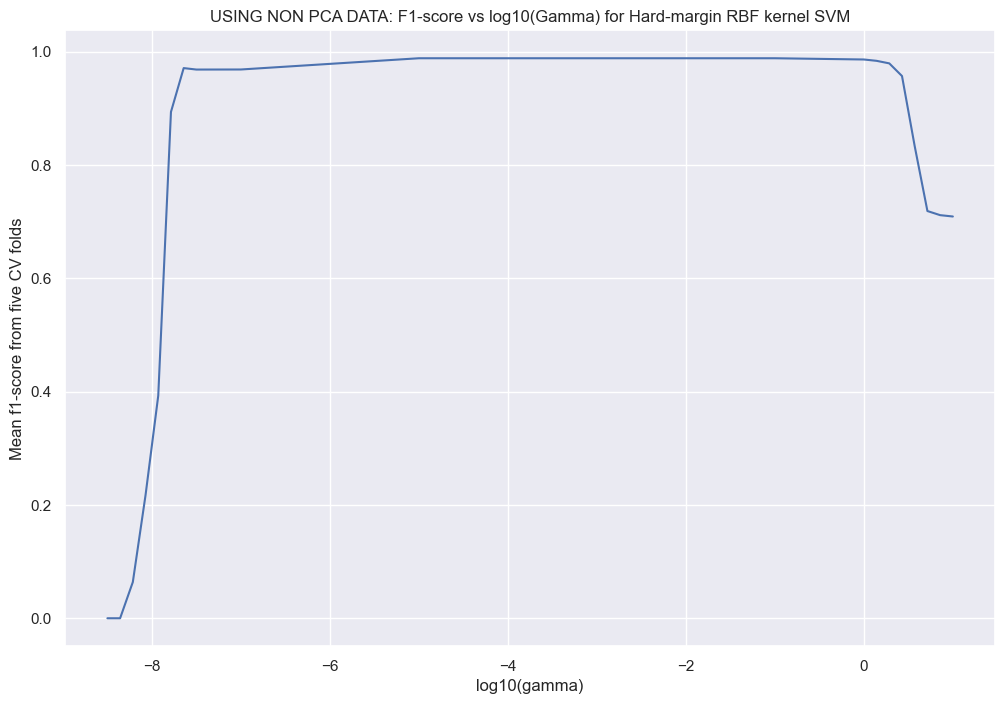

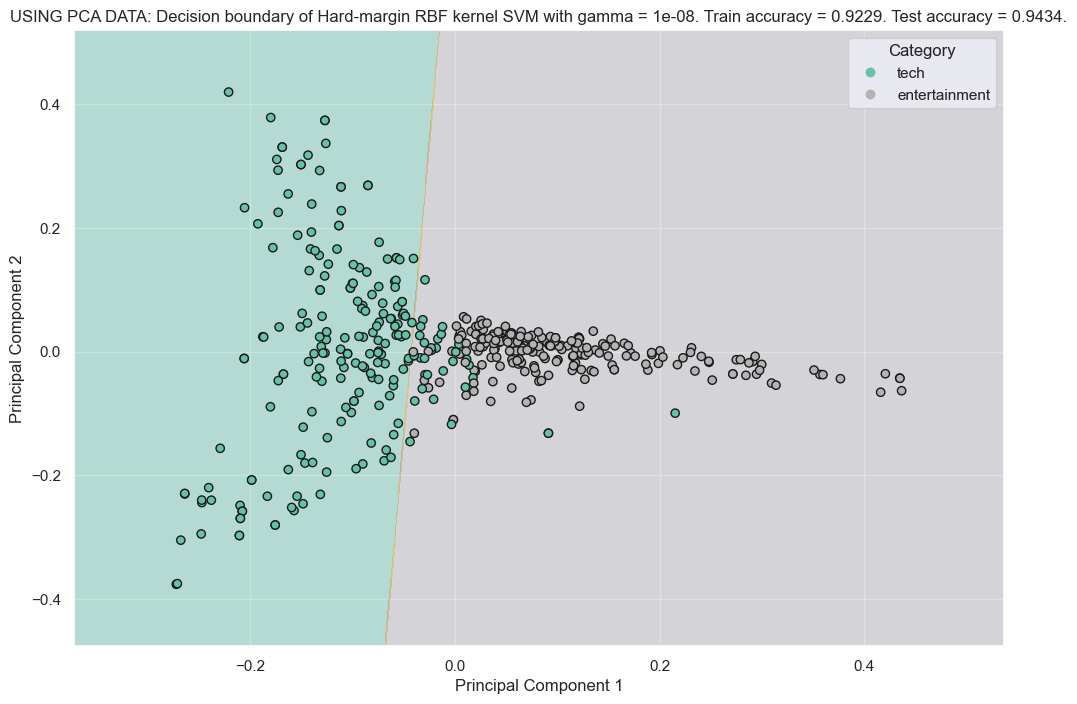

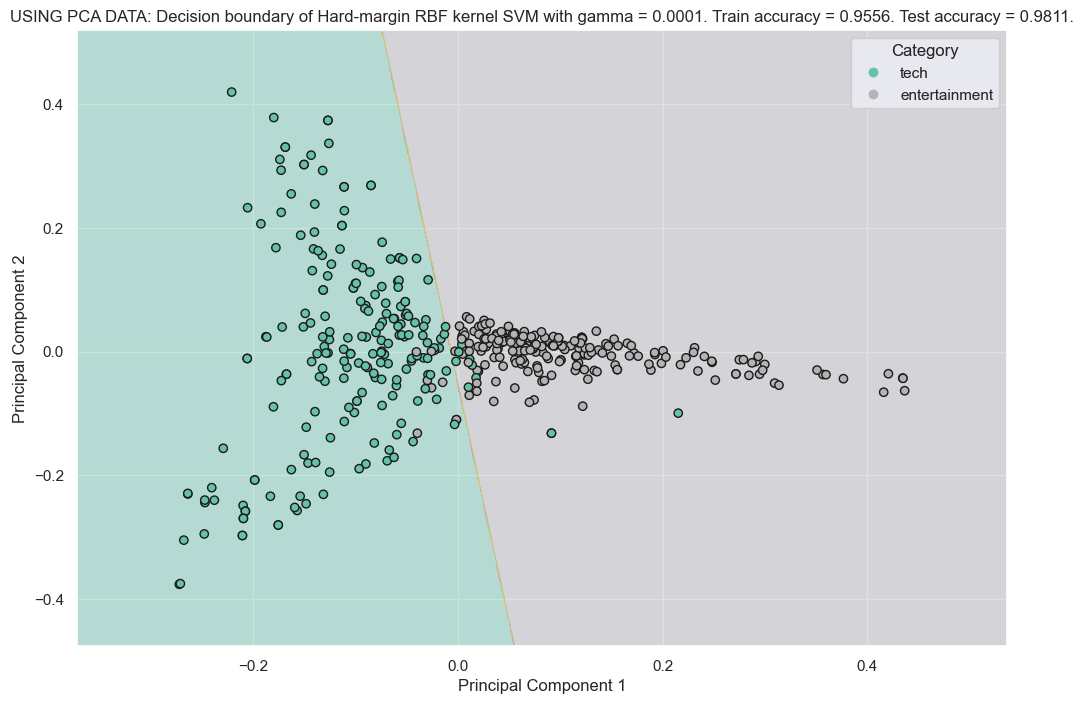

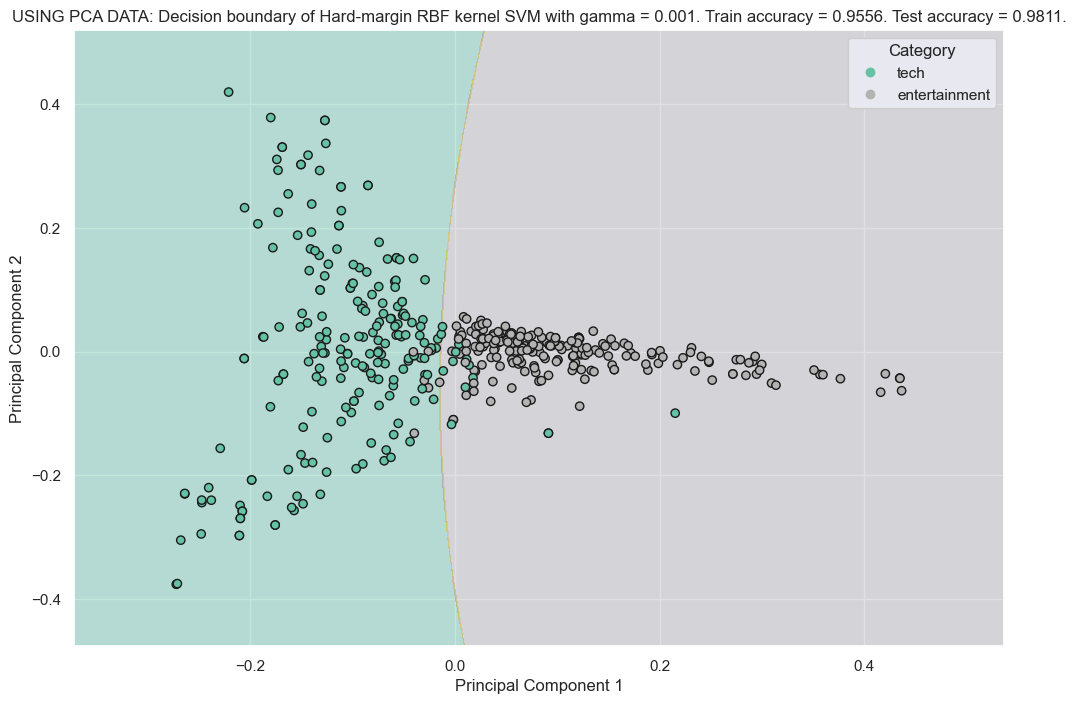

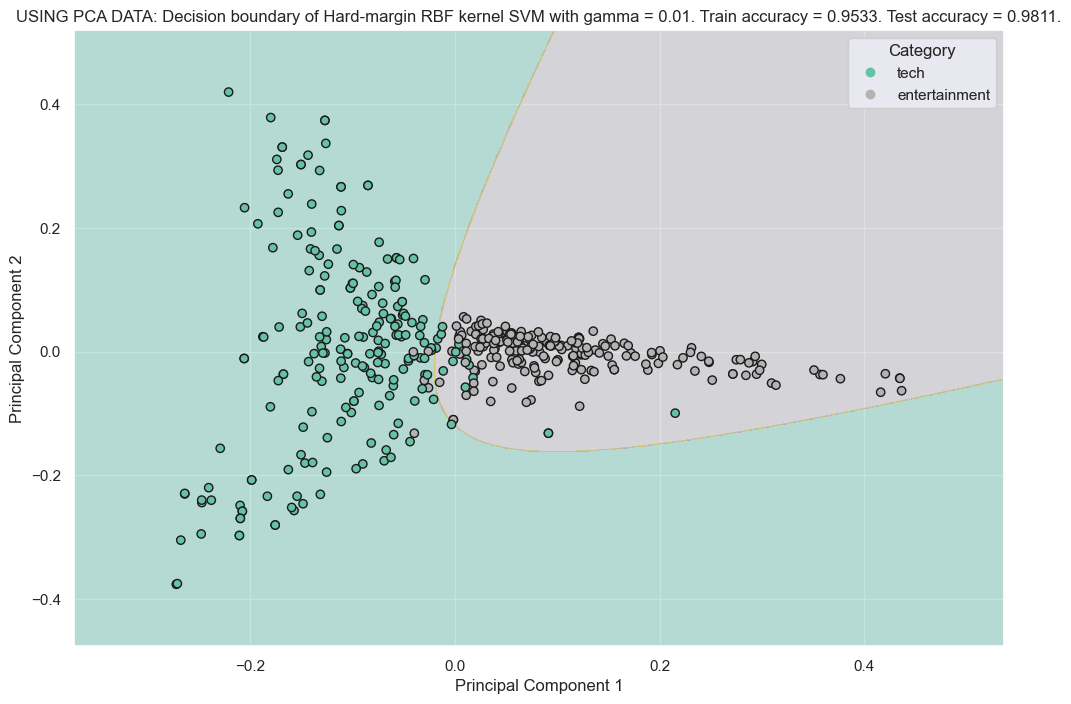

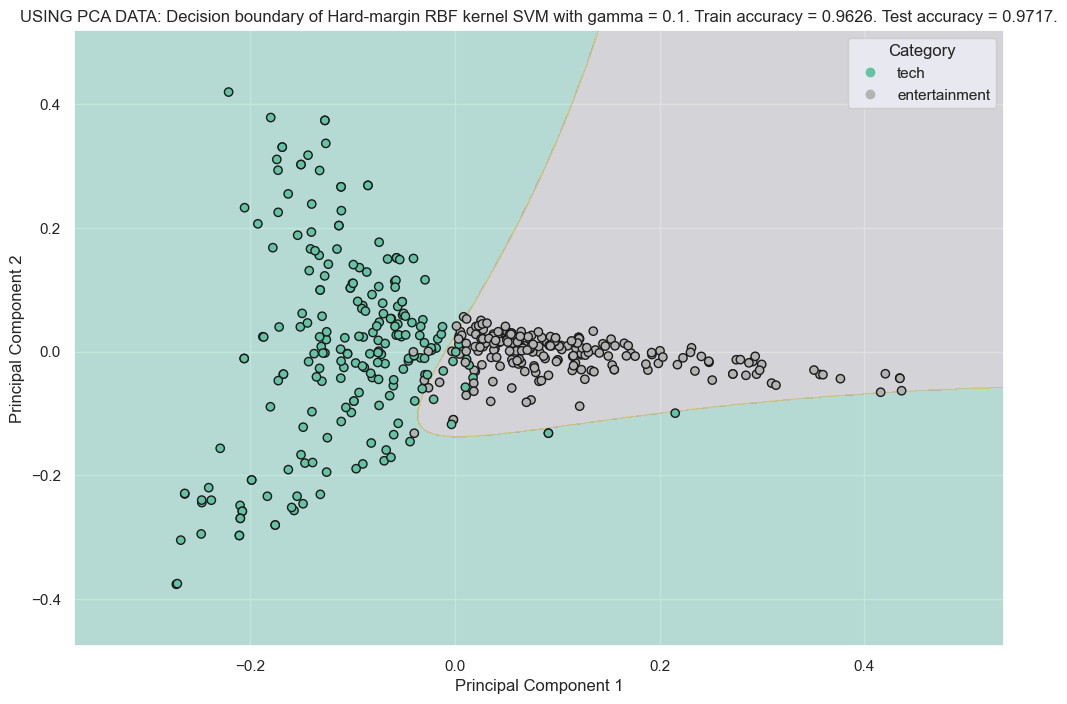

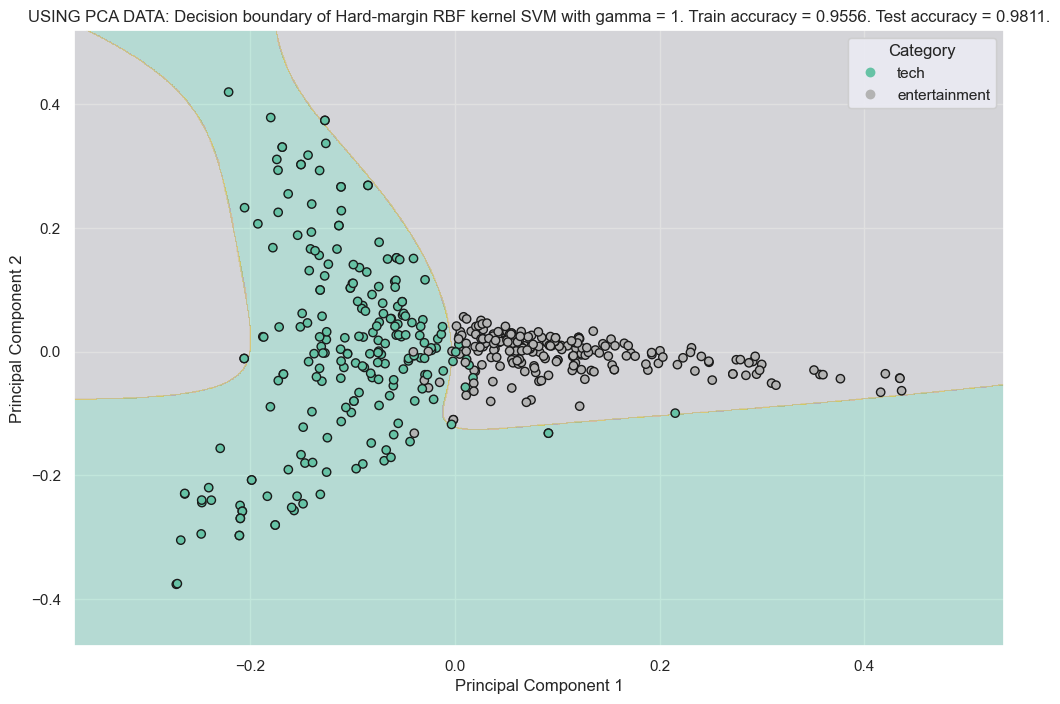

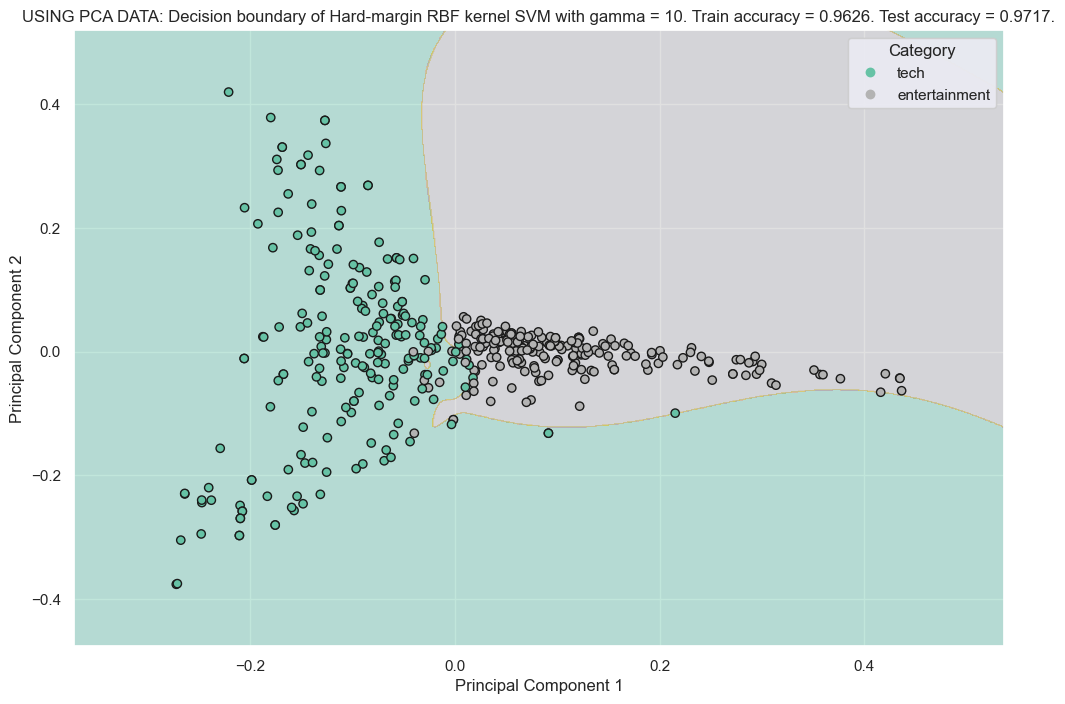

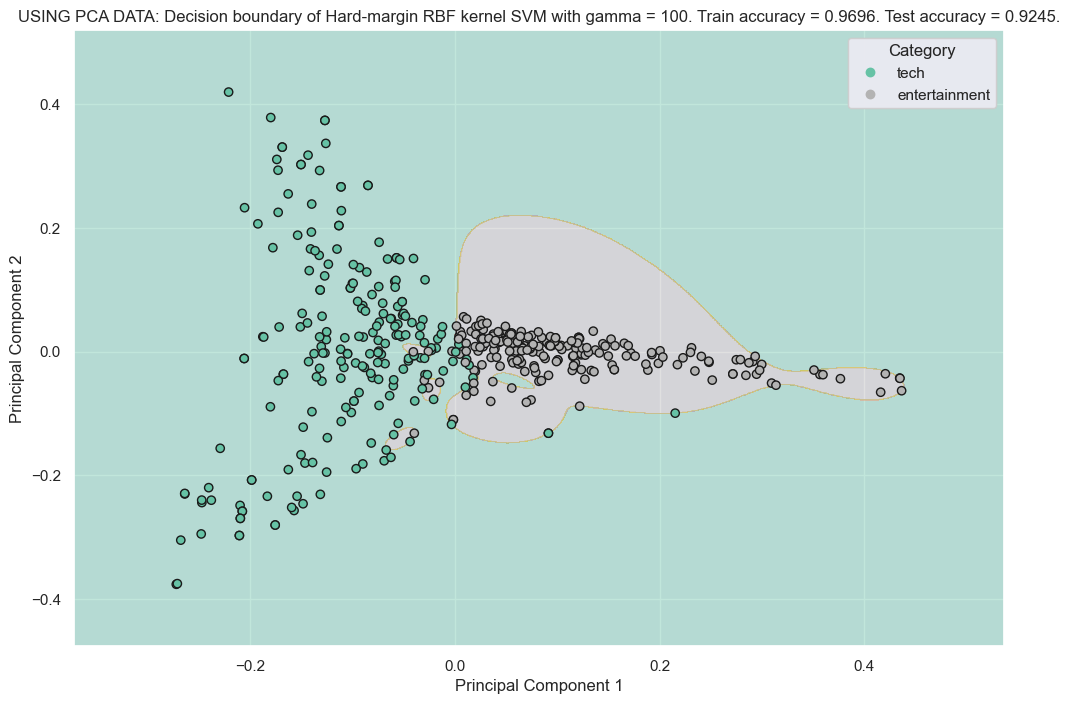

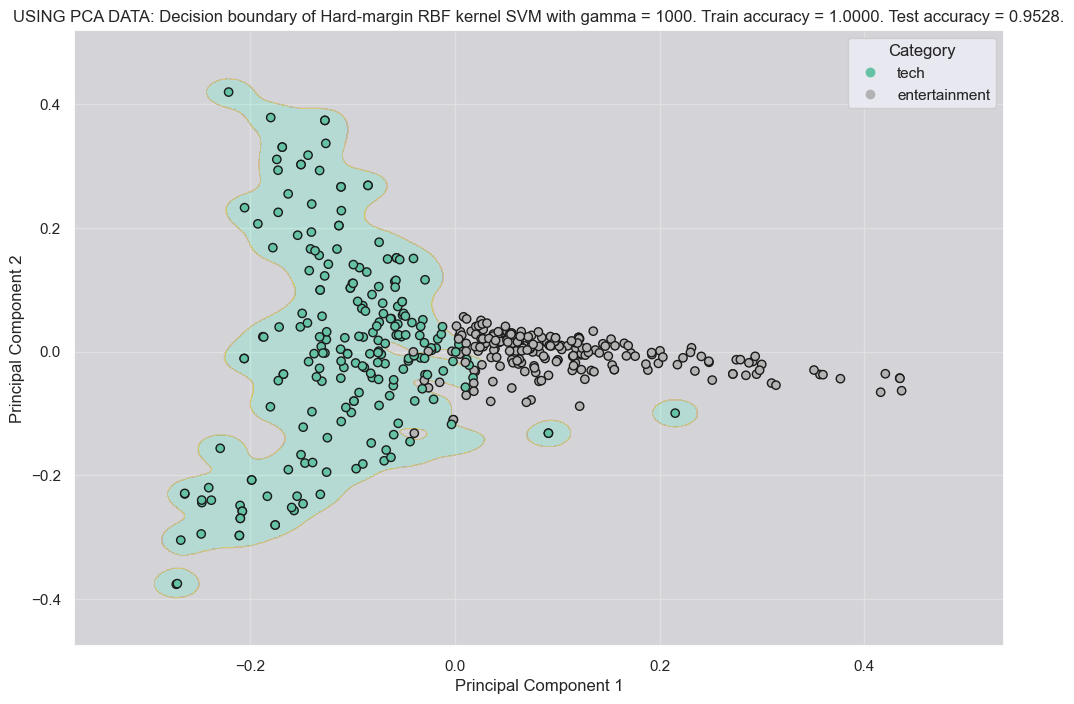

In [73]:
np.random.seed(5)


# CV evaluating effect of gamma on f1-score performance
hyp_arr = np.empty(shape=(20,2))

grange1 = np.logspace(-8.5, -7.5, num = 8)
grange2 = np.logspace(-7, -1, num = 4)
grange3 = np.logspace(0, 1, num = 8)

count = 0

for g in grange1:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
for g in grange2:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1

for g in grange3:
    clf = svm.SVC(kernel='rbf', C=10000000, gamma=g)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(g))
    count += 1
    
    
    
# Draw log10(Gamma) vs F1-score plot
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(gamma)"])
hyp_ax = sns.lineplot(hyp_df, x="log10(gamma)", y="Mean f1-score from five CV folds")
hyp_ax.set_title("USING NON PCA DATA: F1-score vs log10(Gamma) for Hard-margin RBF kernel SVM")






# Apply PCA transform, then train model and draw decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])



gvals = [10 **(-8), 10 **(-4), 10 ** (-3), 10 ** (-2), 0.1, 1, 10, 100, 1000]


for g in gvals:
    rbf_svc = svm.SVC(kernel='rbf', C=1000000000, gamma=g)

    rbf_svc.fit(pca_X_train,Y_train)

    test_score = rbf_svc.score(pca_X_test, Y_test)
    train_score = rbf_svc.score(pca_X_train, Y_train)

    
    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12, 8)
    
    disp = DecisionBoundaryDisplay.from_estimator(rbf_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    labels = ["tech","entertainment"]
    scatterpath = ax.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    leg = ax.legend(scatterpath.legend_elements()[0], labels, loc="upper right", title="Category")
    ax.add_artist(leg)
    
    if g < 1:
        disp.ax_.set_title("USING PCA DATA: Decision boundary of Hard-margin RBF kernel SVM with gamma = %0.1g. Train accuracy = %0.4f. Test accuracy = %0.4f."
                           % (g, train_score, test_score))
    else:
        disp.ax_.set_title("USING PCA DATA: Decision boundary of Hard-margin RBF kernel SVM with gamma = %i. Train accuracy = %0.4f. Test accuracy = %0.4f."
                           % (g, train_score, test_score))
        
    plt.show()




### Hard-margin RBF SVM decision boundaries

From the first decision boundary graph, we see that when gamma is very low, the decision boundary is just a straight line. This straight line is further away from the "clean" split the lower gamma is, then the straight line becomes more of a clean split as gamma increases.

Based on the decision boundary plots, we see that gamma = 0.1 is a good choice for the parameter <ins>for the PCA-transformed data</ins>. Training accuracy is lower at 0.953 but test accuracy goes up to 0.981. We can see the reason why in the decision boundaries. 

When gamma is lower, the decision boundaries are straight. This is when variance is high, and our model is underfitting. The decision bounaries look like a straight line, as if we were using a linear kernal.

When gamma is higher than 0.1, we start to see a higher bias (overfitting). When gamma = 1, we see a "pocket" of entertainment data where there are no examples of the entertainment class in the training set.

When gamma is 1000, we see the extreme case of high bias/overfitting. The decision boundaries form an island around outlier values and seem to completely trace perfectly around the "tech" class. The training accuracy is 100% but the test accuracy goes down to 0.95.

### Actual performance on non-PCA data

From the first graph graphing f1-score as gamma increases, we see that f1-score starts off very low when gamma is very low. The reason for this is seen in the decision boundaries: the separating hyperplane would be very far from the clean split point. As gamma increases, the f1-score increases. Notably, the f1-score stays very high for a wide range of low gamma values. This is because the "straight-line" hyperplane splits would give good results, as our data is linearly separable. 

As gamma appraoches 1, we start to see performance suffer. This is because we start overfitting, as seen in the decision boundaries.

## Soft-margin linear SVM

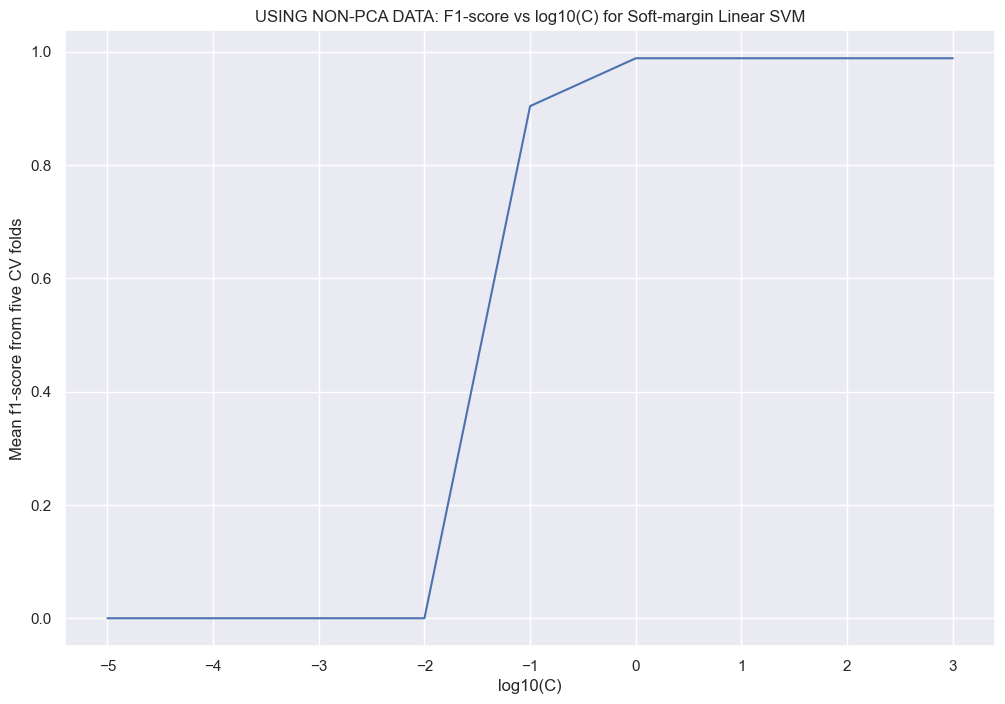

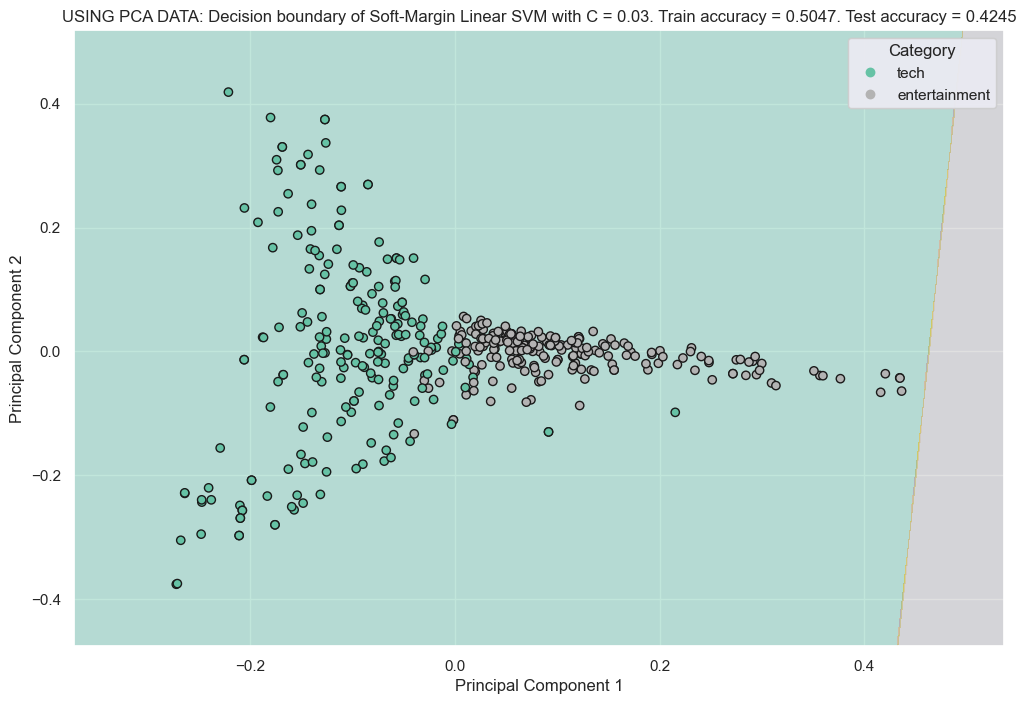

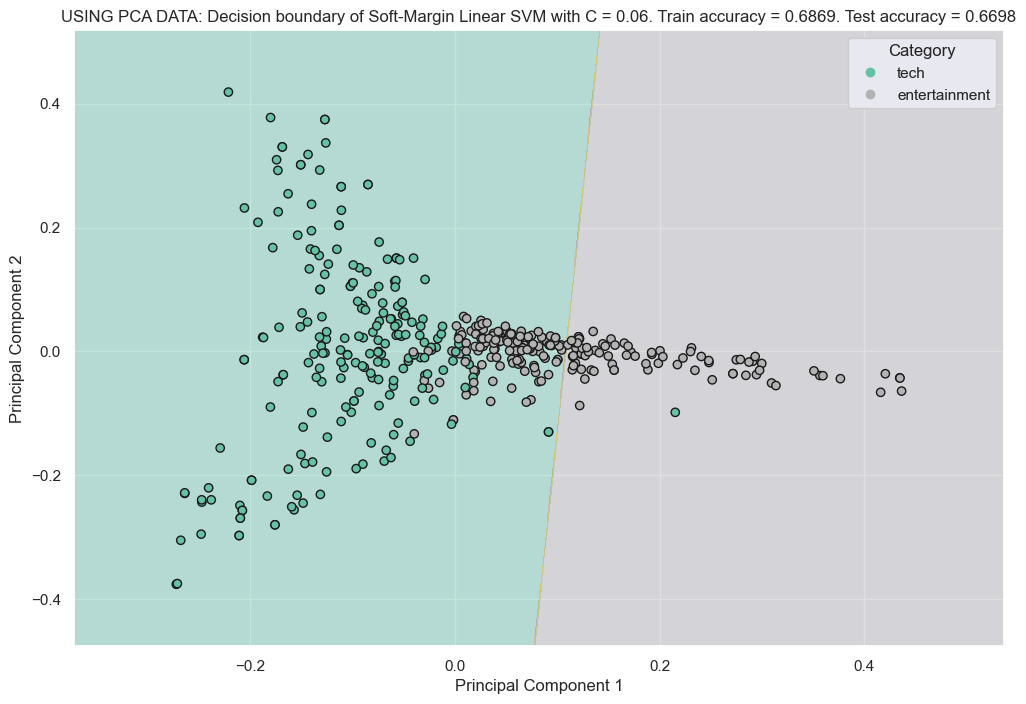

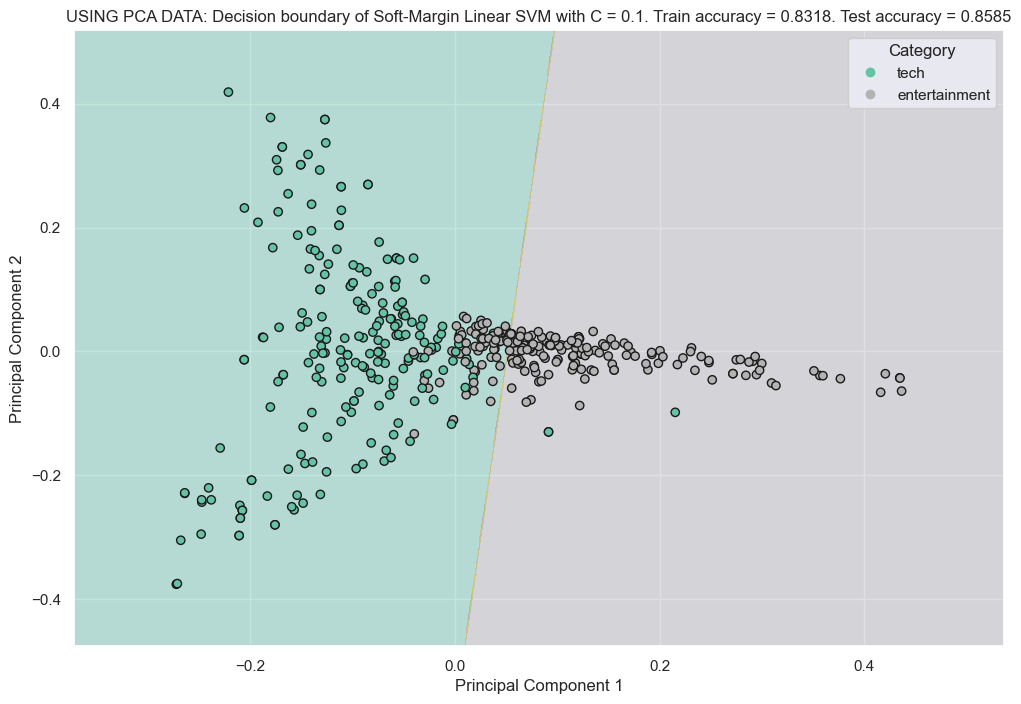

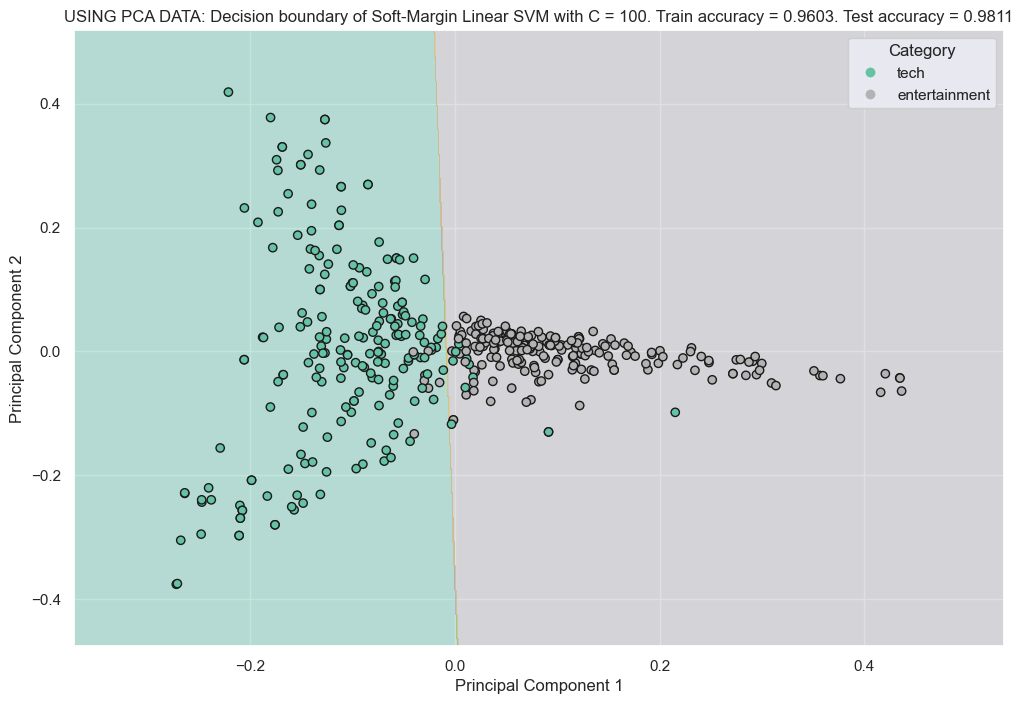

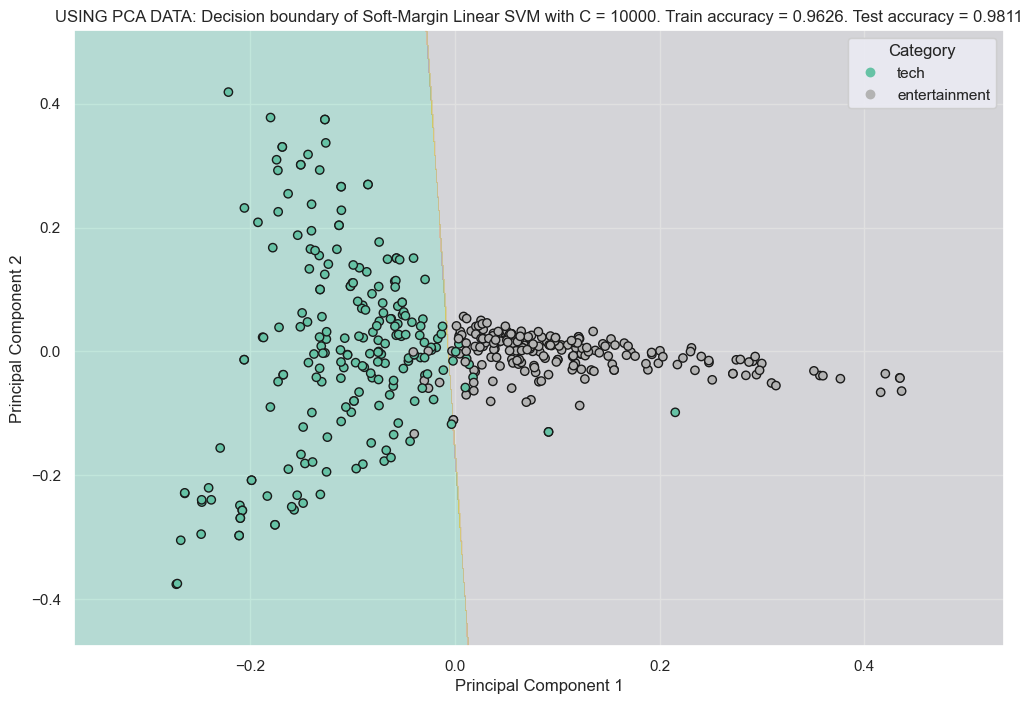

In [71]:
hyp_log = []
scores = []


# CV evaluating effect of C on f1-score performance
hyp_arr = np.empty(shape=(9,2))
crange = np.logspace(-5, 3, num = 9)

count = 0

for c in crange:
    clf = svm.SVC(kernel="linear", C=c)
    cvscores = cross_val_score(clf, prep_X_train, Y_train, cv=5, scoring="f1")
    hyp_arr[count] = (cvscores.mean(), np.log10(c))
    count += 1


    

# Draw log10(C) vs F1-score plot
hyp_df = pd.DataFrame(hyp_arr, columns=["Mean f1-score from five CV folds", "log10(C)"])   
hyp_ax = sns.lineplot(hyp_df, x="log10(C)", y="Mean f1-score from five CV folds")
hyp_ax.set_title("USING NON-PCA DATA: F1-score vs log10(C) for Soft-margin Linear SVM")





# Apply PCA transform, then train model and draw decision boundaries.
pca_transformer = PCA(n_components=2)
pca_transformer.fit(prep_X_train)
vector = pca_transformer.transform(prep_X_train)
pca_X_train = pd.DataFrame(vector, index=prep_X_train.index, columns=["x1", "x2"])

vector = pca_transformer.transform(prep_X_test)
pca_X_test = pd.DataFrame(vector, index=prep_X_test.index, columns=["x1", "x2"])


cvals = [10**(-1.5), 10**(-1.2), 10**(-1), 10**2, 10**4]



for c in cvals:
    lin_svc = svm.SVC(kernel="linear", C=c)

    lin_svc.fit(pca_X_train,Y_train)

    test_score = lin_svc.score(pca_X_test, Y_test)
    train_score = lin_svc.score(pca_X_train, Y_train)



    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12, 8)
    
    disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    
    labels = ["tech","entertainment"]
    scatterpath = ax.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    leg = ax.legend(scatterpath.legend_elements()[0], labels, loc="upper right", title="Category")
    ax.add_artist(leg)
    
    if c < 1:
        disp.ax_.set_title("USING PCA DATA: Decision boundary of Soft-Margin Linear SVM with C = %0.1g. Train accuracy = %0.4f. Test accuracy = %0.4f" 
                           % (c, train_score, test_score))
    else:
        disp.ax_.set_title("USING PCA DATA: Decision boundary of Soft-Margin Linear SVM with C = %i. Train accuracy = %0.4f. Test accuracy = %0.4f" 
                           % (c, train_score, test_score))
        
    plt.show()


### Soft-margin Linear SVM decision boundaries

When C is very low, the error tolerance is very high and our model seeks to <ins>just find the highest margin</ins>. We see that the decision boundary is to the right of ALL the data, so that no training examples of the tech class are accurately classified. Therefore the error of the model on training examples is very high, but the margin on the hyperplane is also very high.

Contrastingly, as C increases, we find that the model seeks to find the line which splits the data the cleanest. We see this reflected in the decision boundaries: as we increase C, the boundary moves closer to the place which seems to bisect the data.

### Actual performance on non-PCA data

In the first graph, we see that the actual performance increases as C increases. Notably, the performance remains high as C increases to very high values. This points to the fact that our data is highly separable, and that accounting for error in performance does not give us a significant improvement in performance. The separability of our data is also reflected in our preliminary analysis.

# Task 3A: SVM

We aim to show the effect of training set size on the performance of SVMs.

We use the RBF kernel to demonstrate this effect. We use the hyperparameter settings that were found to work best from the cross-validation in task 3B. This is done so that the only variable is the size of the training set.

The hyperparameter settings used are:
- Gamma = 0.21544
- C = 1.6681

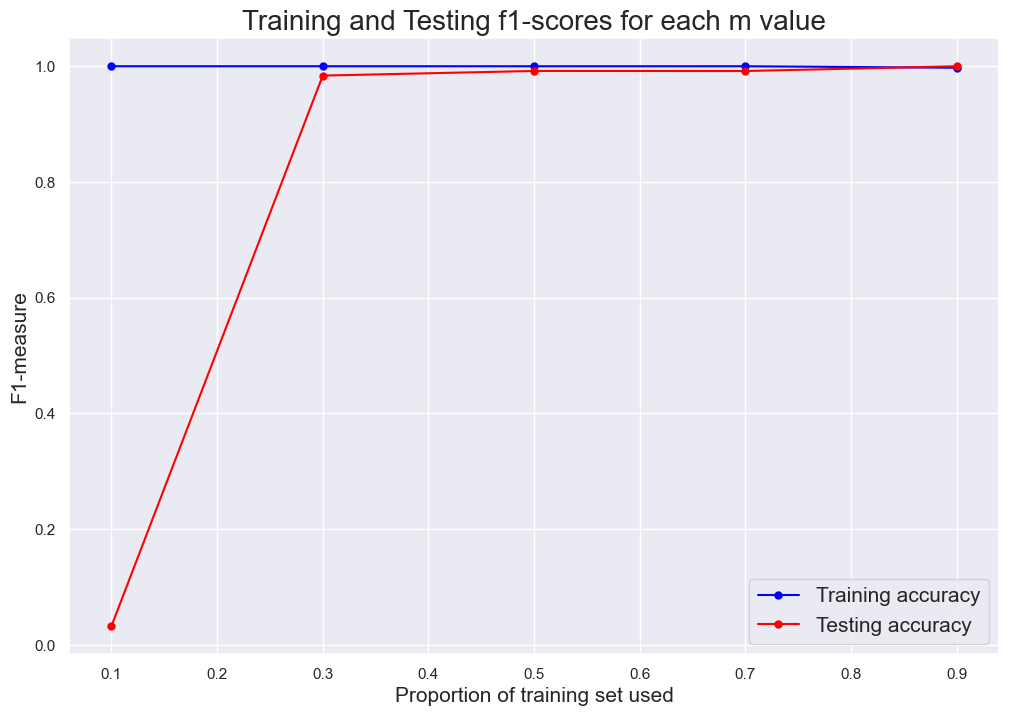

In [81]:
percents = [0.1, 0.3, 0.5, 0.7, 0.9]
test_acc = [None] * 5
train_acc = [None] * 5

for i in range(len(percents)):
    m = percents[i]
    n = math.ceil(len(prep_X_train.index) * m)
    
    clf = svm.SVC(kernel="rbf", C = 1.6681, gamma = 0.21544)
    clf.fit(prep_X_train.iloc[0: n], Y_train.iloc[0: n])
    
    train_preds = clf.predict(prep_X_train.iloc[0: n])
    test_preds = clf.predict(prep_X_test)
    
    train_f1 = f1_score(Y_train.iloc[0: n], train_preds)
    test_f1 = f1_score(Y_test, test_preds)
    
    test_acc[i] = test_f1
    train_acc[i] = train_f1


# Draw training set size vs F1-score plot
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(percents, train_acc, marker='o', markersize = 5, color = 'blue', label = 'Training accuracy') 
plt.plot(percents, test_acc, marker='o', markersize = 5, color = 'red', label = 'Testing accuracy') 
plt.title('Training and Testing f1-scores for each m value', fontsize = 20)
plt.xlabel('Proportion of training set used', fontsize = 15)
plt.ylabel('F1-measure', fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 15)
plt.show()

# Task 3A Analysis

As expected, the test f1-score increases as the size of the training set increases. A larger training set means that we see more examples from each class, so our model will be better able to predict unseen examples. 

In the test set f1-score, we see a dramatic increase from using 10% of the training set to 30%: the test f1-score increases from 0.03 to 0.96. After 30% we see a gradual increase in performance. This indicates that we gain a lot of information from that increase from 10% to 30% of the training set. 

We see that the training accuracy remains the same at 1, only decreasing slightly to 0.99 when 90% of the training set is used. This indicates that when the training set is small, the data is more sparse so our model is better able to completely separate the data. When the training set gets larger, we may be more likely to see examples in the two classes that are more similar. Hence we cannot separate the examples without overfitting to the training set.

Since we used the hyperparameters from our best performing model, the consistently high training f1-score points to the fact that our data is highly separable, so we can have high training accuracy without sacrificing test accuracy.

# Task 3B: SVM

### Method

Now we find the best kernel and hyperparameters for the SVM. For the measure of performance, we take the mean f1-score across 5 cross validation folds.

We test four kernels: Linear, RBF, Polynomial, and Sigmoid.

For each kernel, the hyperparameters are:
- Linear: C
- RBF: C, gamma
- Sigmoid: C, gamma
- Polynomial: C, gamma, degree

We use GridSearchCV to find the best combination of hyperparameters for each kernel.

For each hyperparameter, the range of values we test are:
- C: in base-10 logspace, 12 evenly-spaced values between -2 and 2
- Gamma: in base-10 logspace, 12 evenly-spaced values between -2 and 2
- Degree: we test 3 degrees of polynomial: 1, 2, and 3.

We use logspace for C and gamma because we want to fine-tune the parameter for values closer to 1 (10^0). As an example, take gamma. As the value of gamma increases, we see extreme overfitting and our model will likely suffer in performance. Low values of gamma means we underfit, and for the same reason the model will suffer.

The extreme values are more likely to see the performance of the model suffer, so there is no need to fine-tune in this range. If our search reveals that the extreme values are preferred, we can simply adjust the range and initiate the seach again.

In [79]:
# For each kernel, we find the best combination of hyperparameter settings.
cvals = np.logspace(-2, 2, 10)
pgrid = { "C" : cvals }

svc = svm.SVC(kernel="linear")
lin_cv = GridSearchCV(svc, pgrid, scoring="f1", n_jobs=-1)
lin_cv.fit(prep_X_train, Y_train)




gvals = np.logspace(-2, 2, 10)
pgrid["gamma"] = gvals

svc = svm.SVC(kernel="rbf")
rbf_cv = GridSearchCV(svc, pgrid, scoring="f1", n_jobs=-1)
rbf_cv.fit(prep_X_train, Y_train)


svc = svm.SVC(kernel="sigmoid")
sig_cv = GridSearchCV(svc, pgrid, scoring="f1", n_jobs=-1)
sig_cv.fit(prep_X_train, Y_train)




dvals = [1, 2, 3]
pgrid["degree"] = dvals

svc = svm.SVC(kernel="poly")
pol_cv = GridSearchCV(svc, pgrid, scoring="f1", n_jobs=-1)
pol_cv.fit(prep_X_train, Y_train)


GridSearchCV(estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'degree': [1, 2],
                         'gamma': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='f1')

In [80]:
# For each kernel, find the best-performing hyperparameter combinations. Find the f1-score of each model
# on the test set and the training set.
print("Best hyperparameters for the Linear SVM are:")
print("C = %0.5g" % lin_cv.best_params_["C"])
print("Test set f1-score of tuned Linear SVM is %0.4f." % (lin_cv.score(prep_X_test, Y_test)))
      
train_preds = lin_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned Linear SVM is %0.4f.\n\n" % (train_score))




rbf_cv.cv_results_
print("Best hyperparameters for the RBF SVM are:")
print("C = %0.5g" % rbf_cv.best_params_["C"])
print("Gamma = %0.5g" % rbf_cv.best_params_["gamma"])
print("Test set f1-score of tuned RBF SVM is %0.4f." % (rbf_cv.score(prep_X_test, Y_test)))
      
train_preds = rbf_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned RBF SVM is %0.4f.\n\n" % (train_score))




sig_cv.cv_results_
print("Best hyperparameters for the Sigmoid SVM are:")
print("C = %0.5g" % sig_cv.best_params_["C"])
print("Gamma = %0.5g" % sig_cv.best_params_["gamma"])
print("Test set f1-score of tuned Sigmoid SVM is %0.4f." % (sig_cv.score(prep_X_test, Y_test)))

train_preds = sig_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned Sigmoid SVM is %0.4f.\n\n" % (train_score))




pol_cv.cv_results_
print("Best hyperparameters for the Polynomial SVM are:")
print("C = %0.5g" % pol_cv.best_params_["C"])
print("Gamma = %0.5g" % pol_cv.best_params_["gamma"])
print("Degree = %i" % pol_cv.best_params_["degree"])
print("Test set f1-score of tuned Polynomial SVM is %0.4f." % (pol_cv.score(prep_X_test, Y_test)))

train_preds = pol_cv.best_estimator_.predict(prep_X_train)
train_score = f1_score(Y_train, train_preds)
print("Training set f1-score of tuned Polynomial SVM is %0.4f.\n\n" % (train_score))






Best hyperparameters for the Linear SVM are:
C = 0.59948
Test set f1-score of tuned Linear SVM is 0.9917.
Training set f1-score of tuned Linear SVM is 0.9976.


Best hyperparameters for the RBF SVM are:
C = 1.6681
Gamma = 0.21544
Test set f1-score of tuned RBF SVM is 0.9917.
Training set f1-score of tuned RBF SVM is 0.9976.


Best hyperparameters for the Sigmoid SVM are:
C = 0.077426
Gamma = 12.915
Test set f1-score of tuned Sigmoid SVM is 0.9836.
Training set f1-score of tuned Sigmoid SVM is 0.9882.


Best hyperparameters for the Polynomial SVM are:
C = 0.01
Gamma = 35.938
Degree = 1
Test set f1-score of tuned Polynomial SVM is 0.9917.
Training set f1-score of tuned Polynomial SVM is 0.9976.




 # Task 3B Analysis

In general, the performance of the models on the training set is better than the performance on the test sets. This indicates that our models could be being overfit to the test set. 

We choose the RBF model as our final model.

To demonstrate the effect of the hyperparameters on each model, we draw the 2D decision boundary plot as we vary the hyperparameters.

This is the procedure we use:
- Use the best performing model.
- Choose a hyperparameter of that model.
- Train the model with a lower value for the chosen hyperparameter, but the same value for the other hyperparameters.
- Train the model with a higher value for the chosen hyperparameter, but the same value for the other hyperparameters.
- Repeat for all hyperparameters.

In [ ]:
cvals = []
for c in cvals:
    lin_svc = svm.LinearSVC(C=c)

    lin_svc.fit(pca_X_train,Y_train)

    preds = lin_svc.predict(pca_X_test)
    score = lin_svc.score(pca_X_test, Y_test)



    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12, 8)
    
    disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    
    labels = ["tech","entertainment"]
    scatterpath = ax.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    leg = ax.legend(scatterpath.legend_elements()[0], labels, loc="upper right", title="Category")
    ax.add_artist(leg)
    
    if c < 1:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %0.1g" % (c))
    else:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %i" % (c))
        
    plt.show()
    

    
    
    
    
    
gvals = []
for g in gvals:
    lin_svc = svm.LinearSVC(C=c)

    lin_svc.fit(pca_X_train,Y_train)

    preds = lin_svc.predict(pca_X_test)
    score = lin_svc.score(pca_X_test, Y_test)



    # Print PCA decision boundaries.
    _, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12, 8)
    
    disp = DecisionBoundaryDisplay.from_estimator(lin_svc, pca_X_train, response_method="predict", ax=ax, 
                                                  alpha=0.4, cmap="Set2", grid_resolution=1000, eps=0.1,
                                                  xlabel="Principal Component 1", ylabel="Principal Component 2")
    
    
    labels = ["tech","entertainment"]
    scatterpath = ax.scatter(pca_X_train["x1"], pca_X_train["x2"], c=Y_train, edgecolor="k", cmap="Set2")
    leg = ax.legend(scatterpath.legend_elements()[0], labels, loc="upper right", title="Category")
    ax.add_artist(leg)
    
    if c < 1:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %0.1g" % (c))
    else:
        disp.ax_.set_title("Decision boundary plot of Soft-Margin Linear SVM with C = %i" % (c))
        
    plt.show()